In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.stats.mstats import gmean
from sklearn.linear_model import LinearRegression
%matplotlib inline
from itertools import combinations
from itertools import chain
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

tools_path = '../code/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools
from tools import mutant_colorset
from tools import condition_colorset

In [4]:
cov_thresh = 1e6
# fitness_data = p.read_csv('../data/fitnesses_merged_NoWeight_plusflat_resample1000000.csv')
fitness_data = p.read_csv('../data/fitnesses_merged_NoWeight_wTechnicalandResamples_ByTimepoint.csv')
fitness_data = p.read_csv('../data/fitnesses_merged_NoWeight_wTechnical_ByTimepoint.csv')
fitness_data = p.read_csv('../data/fitnesses_merged_default_technical_timepoint.csv')

In [5]:
fitness_data['EE_fitness']

0      0.527685
1      0.759992
2      0.523773
3      0.508768
4      0.403223
5      0.384731
6           NaN
7      0.455321
8      0.724028
9      0.431977
10          NaN
11          NaN
12     0.478727
13     0.473405
14     0.470359
15     0.478798
16     0.019637
17     0.035227
18     0.412557
19     0.548355
20     0.149474
21     0.464464
22     0.263832
23     0.277038
24     0.460584
25     0.400502
26     0.492403
27          NaN
28     0.468529
29          NaN
         ...   
518    0.008202
519         NaN
520    0.458826
521         NaN
522    0.092052
523         NaN
524         NaN
525         NaN
526         NaN
527         NaN
528         NaN
529         NaN
530    0.062673
531    0.065427
532    0.196581
533    0.188432
534    0.154720
535    0.114611
536    0.217628
537   -0.059829
538    0.237911
539    0.113892
540         NaN
541    0.041592
542   -0.036222
543   -0.098804
544    0.134237
545         NaN
546    0.205389
547    0.109638
Name: EE_fitness, Length

In [6]:
fitness_data['1BB_M3_fitness']

0      0.349259
1      1.007577
2      0.344703
3      0.827609
4      0.756085
5      0.988022
6      0.000000
7      0.329384
8      1.022583
9      0.321022
10     0.000000
11     0.000000
12     0.961642
13     0.964540
14     0.307970
15     0.728691
16     0.076793
17     0.006800
18     0.740677
19     0.328808
20     0.393015
21     0.746808
22     0.795788
23     0.499664
24     0.708998
25     0.367187
26     0.472345
27     0.517315
28     0.339705
29     0.000000
         ...   
518    0.000067
519    0.000000
520    0.324922
521    0.205620
522    0.044587
523    0.537683
524    0.000000
525    0.000000
526    0.791221
527    0.000000
528    0.430724
529    0.000000
530    0.674595
531    0.681502
532    0.689983
533    0.680884
534    0.692349
535    0.666434
536    0.673636
537    0.687453
538    0.702440
539    0.860423
540    0.954055
541    0.879110
542    0.867291
543    0.872156
544    0.778986
545    0.000000
546    0.857915
547    0.876397
Name: 1BB_M3_fitness, Le

In [7]:
mutant_train_set = p.read_csv('../data/mutant_train_set.csv')
training_bcs = mutant_train_set['barcode'].values

In [8]:
old_conditions = {
                  '3':['3.1','3.2','3.3'],
                  '6':['6.1','6.2','6.3'],
                  '13':['13.1','13.2','13.3'],
                  '18':['18.1','18.2','18.3'],
                  '20':['20.1','20.2','20.3'],
                  '21':['21.1','21.2','21.3'],
                  '23':['23.1','23.2','23.3']
                 }

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
                        '1BB_0.2MNaCl' :['K','L'],
#                         '1BB_0.2MNaCl' :['K'], 
                        '1BB_0.5MNaCl' :['M','N'],
                        '1BB_0.2MKCl' :['O'],
                        '1BB_0.5MKCl' :['P'],
                        '1BB_8.5uMGdA' :['Q','R'],
                        '1BB_17uMGdA' :['S','T'],
                        '1BB_2ugFlu' :['U','V'],
                        '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
                        '1BB_1%EtOH' :['EE','FF'],
                        '1BB_SucRaf' :['GG'],
                      }


# m3_conditions = {**old_conditions,}
conditions = {**old_conditions, **bigbatch_conditions}
all_conditions = conditions.keys()
all_reps = [rep for reps in conditions.values() for rep in reps]

m3_conditions = list(old_conditions.keys()) + ['1BB_M3']
m3_reps = [rep for condition in m3_conditions for rep in conditions[condition]]



In [9]:
list(old_conditions.keys())

['3', '6', '13', '18', '20', '21', '23']

In [10]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

fitness_cols = [col for col in this_data.columns if '_fitness' in col]

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]




In [11]:
bigbatch_conditions.keys()

dict_keys(['1BB_M3', '1BB_Baffle', '1BB_1.4%Gluc', '1BB_1.8%Gluc', '1BB_0.2MNaCl', '1BB_0.5MNaCl', '1BB_0.2MKCl', '1BB_0.5MKCl', '1BB_8.5uMGdA', '1BB_17uMGdA', '1BB_2ugFlu', '1BB_0.5ugFlu', '1BB_1%Raf', '1BB_0.5%Raf', '1BB_1%Gly', '1BB_1%EtOH', '1BB_SucRaf'])

In [12]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

train_cols = [col + '_fitness' for col in m3_conditions]
test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]


fitness_cols = train_cols + test_cols

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

# train_cols = [col+'_original_fitness' for col in [col.split('_')[0] for col in fitness_cols] if col in m3_reps]
# test_cols =  [col+'_original_fitness'  for col in [col.split('_')[0] for col in fitness_cols] if col not in m3_reps]



(-1.1, 1.1)

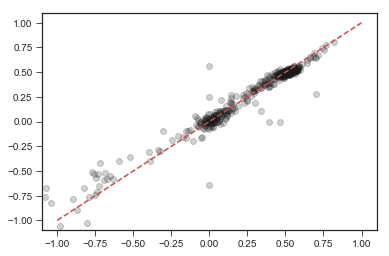

In [13]:
plt.scatter(fitness_data['1BB_0.2MKCl_fitness'],fitness_data['1BB_0.2MNaCl_fitness'],color='k',alpha=0.2)
plt.plot([-1,1],[-1,1],'r--')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

1BB_Baffle
1BB_1.4%Gluc
1BB_1.8%Gluc
1BB_0.2MNaCl
1BB_0.5MNaCl
1BB_0.2MKCl
1BB_0.5MKCl
1BB_8.5uMGdA
1BB_17uMGdA
1BB_2ugFlu
1BB_0.5ugFlu
1BB_1%Raf
1BB_0.5%Raf
1BB_1%Gly
1BB_1%EtOH
1BB_SucRaf


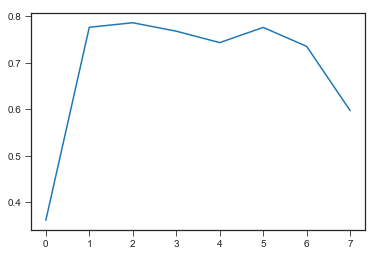

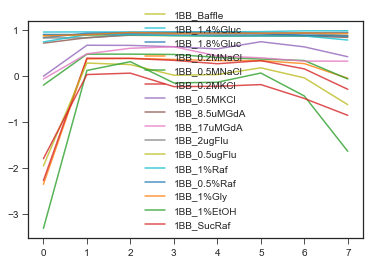

In [14]:

train_conditions = train_cols
# train_conditions = test_cols
train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

test_conditions = test_cols
# test_conditions = train_cols
# test_conditions = [rep for rep in  test_conditions if rep.split('_')[0] in all_reps]
test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]




all_locs = sorted(list(train_locs)+list(test_locs))

this_fitness = fitness[:,all_locs]
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]



train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]


by_rank, by_condition, by_mutant, mean_fits, guesses = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=True)
by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)
plt.figure()
start = 0
already_plotted = []



for k,condition in enumerate(test_conditions):
    condition = condition.split('_fitness')[0]
    print(condition)
#     condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    condition_name = condition
    index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
    
    index =  index % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x12e313e80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x11e123e48> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x135b63ac8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning:

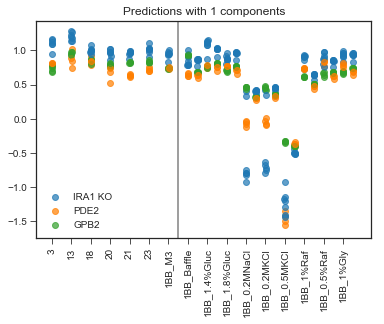

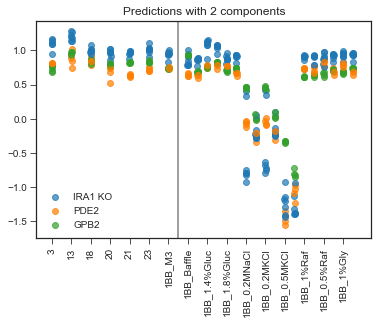

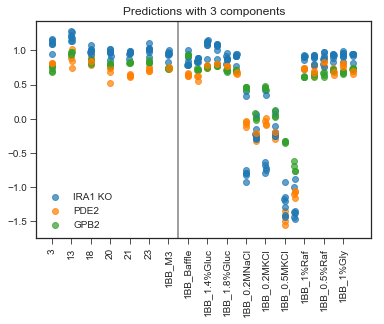

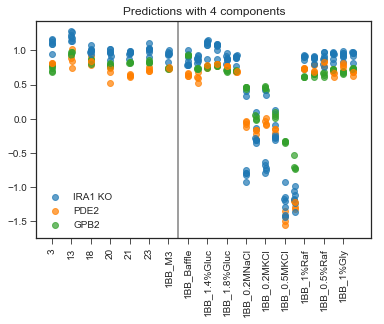

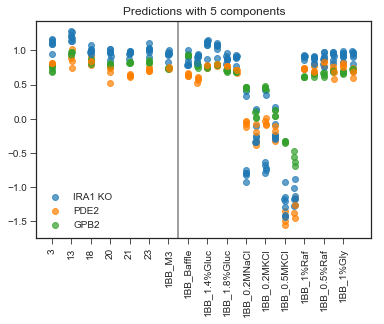

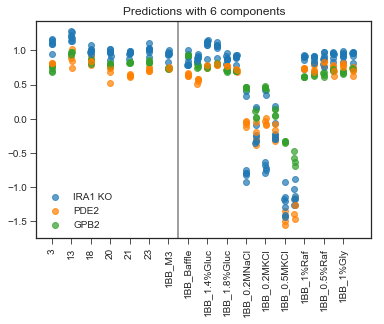

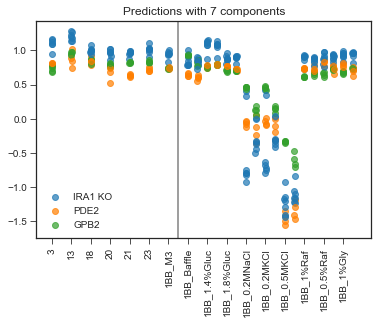

In [237]:
test_mutant_data = this_data[~this_data['barcode'].isin(training_bcs)]


this_gene = ['GPB2','PDE2','IRA1','Diploid']
# this
this_gene_data = test_mutant_data[test_mutant_data['gene'].isin(this_gene)]

type_list = ['nonsense_variant','frameshift_variant']
# type_list = ['missense_variant']
this_gene_data = this_gene_data[this_gene_data['type'].isin(type_list)]


this_gene_locs = np.where(np.isin(test_mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[col].values)) ]

for rank in range(7):
    plt.figure()
    plt.title(f'Predictions with {rank+1} components')
    for i,col in enumerate(train_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    plt.gca().set_prop_cycle(None)
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + 0.5 + jitters[bc]],guesses[rank][this_gene_locs[bc],i],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
#     sns.boxplot(data=guesses[rank][this_gene_locs,:])
    
    plt.axvline(x=len(train_conditions)+0.5,color='gray')
    plt.legend(['_nolegend_','IRA1 KO','PDE2','_nolegend_','GPB2'])
    plt.xticks(range(1,len(train_conditions)+len(test_conditions)+1),[col.split('_fitness')[0] for col in (train_conditions + test_conditions)],rotation=90)
    
    
#     plt.savefig('predictions_by_gene_{rank+1}components.pdf',bbox_inches='tight')

In [ ]:
test_mutant_data = this_data[~this_data['barcode'].isin(training_bcs)]


this_gene = ['GPB2','PDE2','IRA1']
# this
this_gene_data = test_mutant_data[test_mutant_data['gene'].isin(this_gene)]

type_list = ['nonsense_variant','frameshift_variant']
# type_list = ['missense_variant']
this_gene_data = this_gene_data[this_gene_data['type'].isin(type_list)]


this_gene_locs = np.where(np.isin(test_mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[col].values)) ]

for rank in range(7):
    plt.figure()
    plt.title(f'Predictions with {rank+1} components')
    for i,col in enumerate(train_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    plt.gca().set_prop_cycle(None)
#     for i,col in enumerate(test_conditions):
#         for bc in range(len(this_gene_data[col].values)):
#             plt.scatter([len(train_conditions)+i + 1 + 0.5 + jitters[bc]],guesses[rank][this_gene_locs[bc],i],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    sns.boxplot(data=guesses[rank][this_gene_locs,:])
    
    plt.axvline(x=len(train_conditions)+0.5,color='gray')
    plt.legend(['_nolegend_','IRA1 KO','PDE2','_nolegend_','GPB2'])
    plt.xticks(range(1,len(train_conditions)+len(test_conditions)+1),[col.split('_fitness')[0] for col in (train_conditions + test_conditions)],rotation=90)
    
    
#     plt.savefig('predictions_by_gene_{rank+1}components.pdf',bbox_inches='tight')

1BB_Baffle
1BB_1.4%Gluc
1BB_1.8%Gluc
1BB_0.2MKCl
1BB_0.5MKCl
1BB_1%Raf
1BB_0.5%Raf
1BB_1%Gly


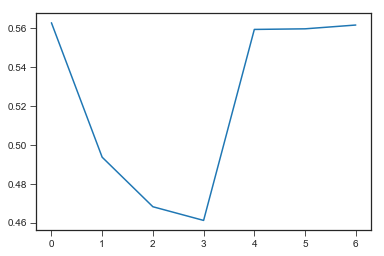

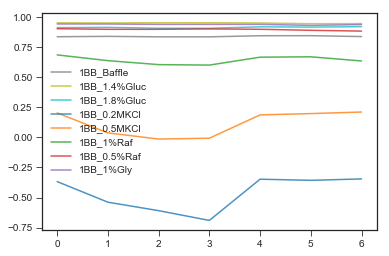

In [195]:

train_conditions = train_cols
# train_conditions = test_cols
train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

test_conditions = test_cols
# test_conditions = train_cols
# test_conditions = [rep for rep in  test_conditions if rep.split('_')[0] in all_reps]
test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]




all_locs = sorted(list(train_locs)+list(test_locs))

this_fitness = fitness[:,all_locs]
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]



train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]


by_rank, by_condition, by_mutant, mean_fits, guesses = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=True,permuted_mutants=True)
by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)
plt.figure()
start = 0
already_plotted = []



for k,condition in enumerate(test_conditions):
    condition = condition.split('_fitness')[0]
    print(condition)
#     condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    condition_name = condition
    index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
    
    index =  index % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend()

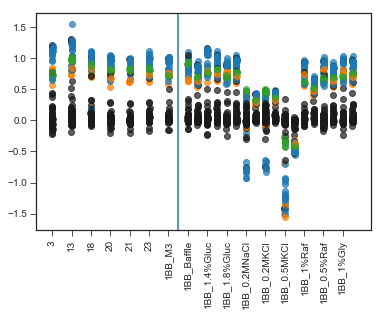

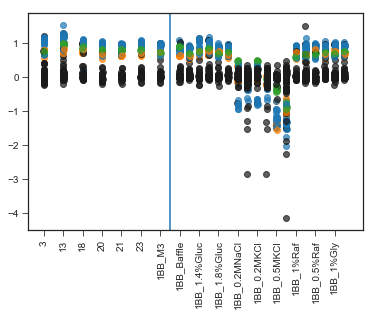

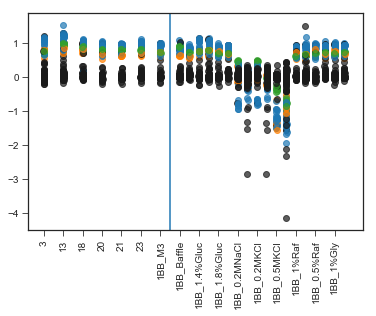

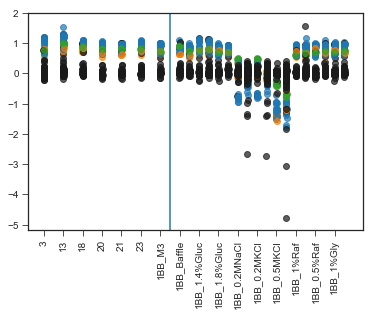

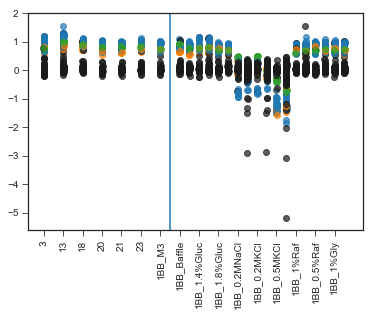

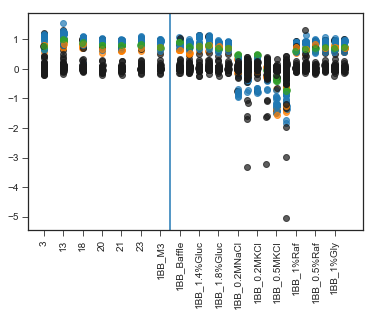

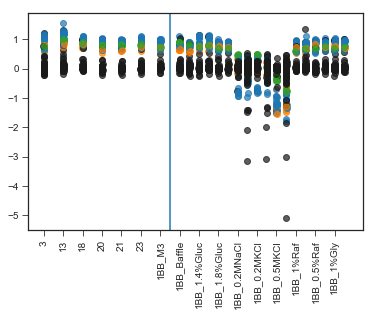

In [215]:
test_mutant_data = this_data[~this_data['barcode'].isin(training_bcs)]


this_gene = ['GPB2','PDE2','IRA1','other']
this_gene_data = test_mutant_data[test_mutant_data['gene'].isin(this_gene)]

# type_list = ['nonsense_variant','frameshift_variant']
# type_list = ['missense_variant']
# this_gene_data = this_gene_data[this_gene_data['type'].isin(type_list)]


this_gene_locs = np.where(np.isin(test_mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[col].values)) ]

for rank in range(7):
    plt.figure()
    for i,col in enumerate(train_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    plt.gca().set_prop_cycle(None)
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + 0.5 + jitters[bc]],guesses[rank][this_gene_locs[bc],i],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
#     plt.boxplot(guesses[rank][this_gene_locs,:])
    plt.axvline(x=len(train_conditions)+0.5)
    plt.xticks(range(1,len(train_conditions)+len(test_conditions)+1),[col.split('_fitness')[0] for col in (train_conditions + test_conditions)],rotation=90)

In [ ]:
for condition in test_cols:
    test_mutant_data = this_data[~this_data['barocode'].isin(training_bcs)]
    plt.boxplot()

In [12]:
p = Pool(10)
entries = [[this_fitness,train,test,n_components] for n_components in range(1,25)]
# (,by_condition=True,by_mutant=False)
output = p.starmap(tools.SVD_predictions_train_test_mixnmatch,entries)

KeyboardInterrupt: 

Process ForkPoolWorker-39:
Process ForkPoolWorker-35:
Process ForkPoolWorker-38:
Process ForkPoolWorker-40:
Process ForkPoolWorker-32:
Process ForkPoolWorker-37:
Process ForkPoolWorker-34:
Process ForkPoolWorker-33:
Process ForkPoolWorker-36:
Process ForkPoolWorker-31:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framewo

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1724, in pinv
    u, s, vt = svd(a, full_matrices=False)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1444, in svd
    u, s, vh = gufunc(a, signature=signature, extobj=extobj)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1444, in svd
    u, s, vh = gufunc(a, signature=signature, extobj=extobj)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1444, in svd
    u, s, vh = gufunc(a, signature=signature, extobj=extobj)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg

In [36]:
%%time
if __name__ ==  '__main__': 
    p = Pool(10)
    entries = [[this_fitness,train,test,n_components,False,False] for n_components in range(1,25)]
    # (,by_condition=True,by_mutant=False)
    output = p.starmap(tools.SVD_predictions_train_test_mixnmatch,entries)

CPU times: user 1min 36s, sys: 1min 20s, total: 2min 56s
Wall time: 1h 13min 51s


In [50]:
output[0][0]

[0.7775464290186149,
 -1.7462627649199987,
 -1.7322641952199276,
 -1.8075848574009248,
 -1.8071511589631837,
 -1.8039558786969931,
 -1.8103381478808624,
 -1.8074569334136434,
 -1.7884100100802862,
 -1.794749121032754,
 -1.8362844687658728,
 -1.8034855936533494,
 -1.893842230766019,
 -1.8112373698713573,
 -1.816097188453781,
 -1.8124588165782156,
 -1.8164305059075976,
 -1.8163543693231108,
 -1.8102422591361833,
 -1.796341314905836,
 -1.8078083617314307,
 -1.804494066515543,
 -1.8175237432201117,
 -1.794151939431321]

In [54]:
sort_list = []
for o in output:
    sort_list.append(sorted([(o1,o2) for o1,o2 in zip(o[0],o[4])],reverse=True))
sorted_rank_combos = sort_list  

In [55]:
sorted_rank_combos = sort_list

RuntimeError: Failed to open TrueType font

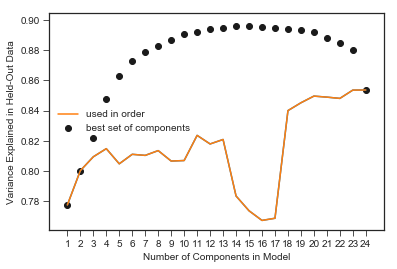

In [57]:
by_rank, by_condition, by_mutant, mean_fits = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=False)
# by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)

for rank in range(len(sorted_rank_combos)):
    plt.scatter(rank,sorted_rank_combos[rank][0][0],color='k',label='best set of components' if rank ==0 else '_nolegend_')
plt.plot(by_rank,label='used in order')
# plt.savefig('predictions_best_per_rank.pdf',bbox_inches='tight')
plt.xticks(range(len(by_rank)),range(1,len(by_rank)+1))
plt.xlabel('Number of Components in Model')
plt.ylabel('Variance Explained in Held-Out Data')
plt.legend()
plt.savefig('best_set_vs_in_order_all.pdf',bbox_inches='tight')

In [31]:
%%time
o = []
for n_components in range(1,5):
    by_rank, by_condition, by_mutant, mean_fits, component_sets = tools.SVD_predictions_train_test_mixnmatch(this_fitness,train,test,n_components,by_condition=True,by_mutant=False)
    o.append(sorted([(rank,combo) for rank,combo in zip(by_rank,component_sets)],reverse=True))



CPU times: user 15.1 s, sys: 470 ms, total: 15.6 s
Wall time: 34.6 s


In [63]:
sorted_rank_combos[6]

[(0.8785819075879436, [0, 1, 2, 9, 10, 12, 17]),
 (0.8770446318593077, [0, 1, 2, 7, 10, 12, 17]),
 (0.8763761257533184, [0, 1, 2, 3, 10, 12, 17]),
 (0.876272100070757, [0, 1, 2, 5, 10, 12, 17]),
 (0.8752940410415991, [0, 1, 2, 10, 12, 17, 19]),
 (0.8739377955644658, [0, 1, 2, 10, 12, 16, 17]),
 (0.8737460397343314, [0, 1, 2, 6, 10, 12, 17]),
 (0.873565355369854, [0, 1, 2, 10, 11, 12, 17]),
 (0.87297186151656, [0, 1, 2, 3, 8, 10, 17]),
 (0.8727238941920381, [0, 1, 2, 10, 12, 17, 23]),
 (0.8723689696864775, [0, 1, 2, 10, 12, 17, 21]),
 (0.8722390689577192, [0, 1, 2, 10, 12, 17, 20]),
 (0.8714454687763196, [0, 1, 2, 7, 8, 10, 17]),
 (0.8713969764924173, [0, 1, 2, 8, 10, 17, 19]),
 (0.8708718512808002, [0, 1, 2, 10, 12, 17, 18]),
 (0.8708306655632606, [0, 1, 2, 5, 8, 10, 17]),
 (0.8707817426646477, [0, 1, 2, 8, 10, 14, 17]),
 (0.8707719842860515, [0, 1, 2, 3, 5, 10, 17]),
 (0.8704256336135026, [0, 1, 2, 8, 10, 16, 17]),
 (0.870276423848967, [0, 1, 2, 3, 7, 10, 17]),
 (0.8699833141457991, [